In [2]:
!pip install kaggle

from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle (1).json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
!kaggle datasets download -d jehanbhathena/weather-dataset

Dataset URL: https://www.kaggle.com/datasets/jehanbhathena/weather-dataset
License(s): CC0-1.0
 99% 583M/587M [00:17<00:00, 41.5MB/s]
100% 587M/587M [00:17<00:00, 35.4MB/s]


In [5]:
!unzip weather-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/frost/3913.jpg  
  inflating: dataset/frost/3914.jpg  
  inflating: dataset/frost/3915.jpg  
  inflating: dataset/frost/3916.jpg  
  inflating: dataset/frost/3917.jpg  
  inflating: dataset/frost/3918.jpg  
  inflating: dataset/frost/3919.jpg  
  inflating: dataset/frost/3920.jpg  
  inflating: dataset/frost/3921.jpg  
  inflating: dataset/frost/3922.jpg  
  inflating: dataset/frost/3923.jpg  
  inflating: dataset/frost/3924.jpg  
  inflating: dataset/frost/3925.jpg  
  inflating: dataset/frost/3926.jpg  
  inflating: dataset/frost/3927.jpg  
  inflating: dataset/frost/3928.jpg  
  inflating: dataset/frost/3929.jpg  
  inflating: dataset/frost/3930.jpg  
  inflating: dataset/frost/3931.jpg  
  inflating: dataset/frost/3932.jpg  
  inflating: dataset/frost/3933.jpg  
  inflating: dataset/frost/3934.jpg  
  inflating: dataset/frost/3935.jpg  
  inflating: dataset/frost/3936.jpg  
  inflating: dataset/frost/3937.jpg  

In [6]:
import torch, time
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

In [7]:
if torch.cuda.is_available():
    print("Device:",torch.cuda.current_device())
    print("Device Name:",torch.cuda.get_device_name())

Device: 0
Device Name: Tesla T4


In [8]:
img_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(0.4),
    transforms.RandomVerticalFlip(0.3),
    transforms.Resize((240,240)),
    transforms.CenterCrop((240,240)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])
img_transforms

Compose(
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    RandomHorizontalFlip(p=0.4)
    RandomVerticalFlip(p=0.3)
    Resize(size=(240, 240), interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(240, 240))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [9]:
data_dir = "/content/dataset"

dataset = datasets.ImageFolder(root=data_dir,transform=img_transforms)

In [10]:
type(dataset)

torchvision.datasets.folder.ImageFolder

In [11]:
len(dataset)

6862

In [12]:
train_set, test_set = random_split(dataset=dataset,lengths=[0.8,0.2])

In [13]:
train_loader = DataLoader(dataset=train_set,batch_size=32,shuffle=True,pin_memory=True,pin_memory_device="cuda")
test_loader = DataLoader(dataset=test_set,batch_size=32,shuffle=True,pin_memory=True,pin_memory_device="cuda")

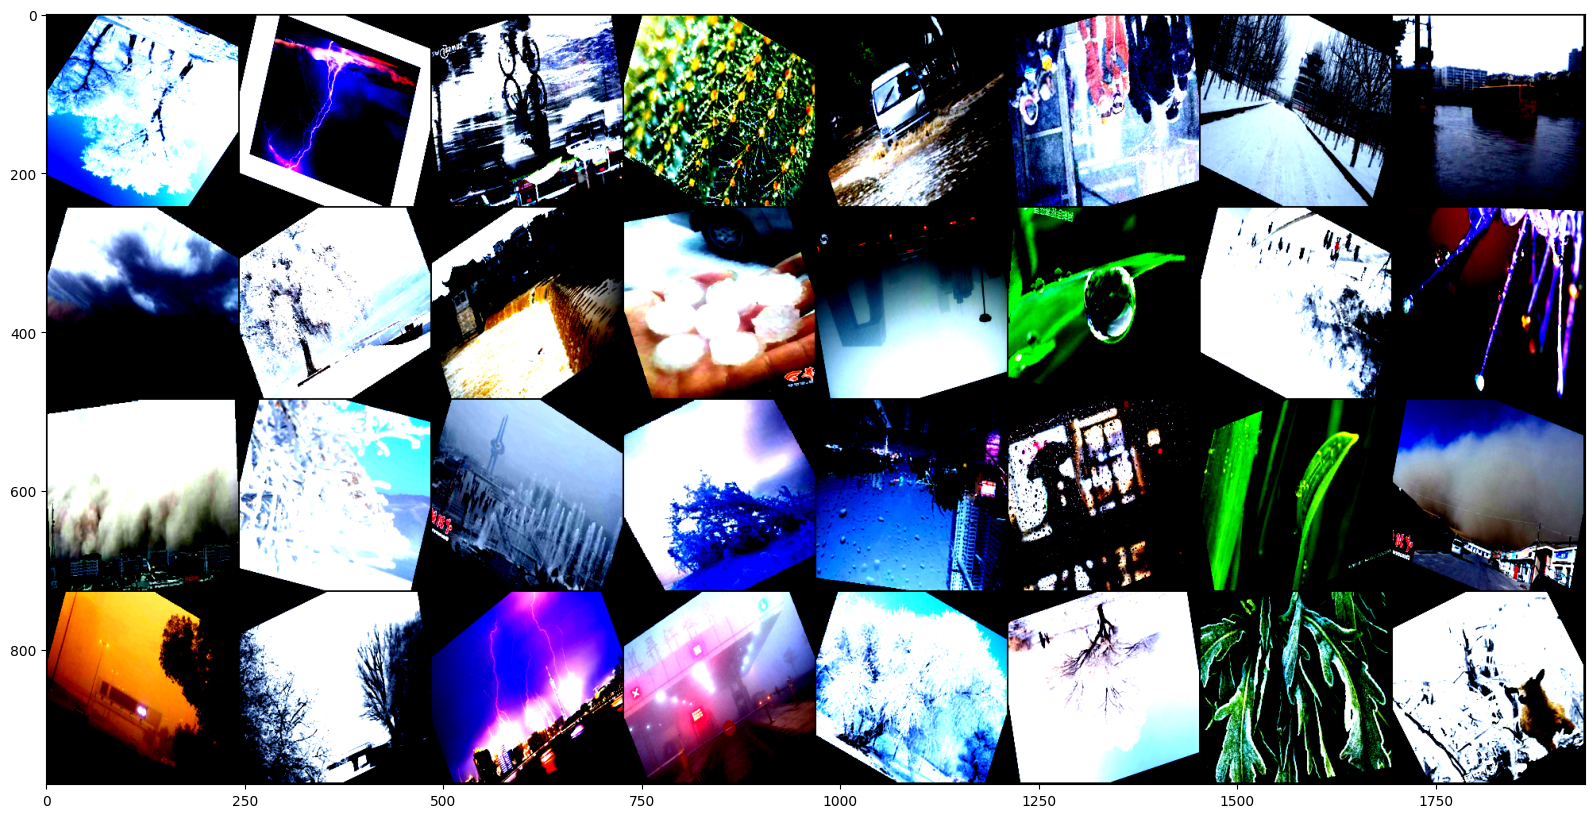

In [14]:
for images, labels in train_loader:
    break
img_grid = make_grid(images,nrow=8)

inv_normalize = transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],std=[1/0.229,1/0.224,1/0.225])
inv_normalized_images = inv_normalize(images)

plt.figure(figsize=(20,10))
plt.imshow(np.transpose(img_grid.numpy(),(1,2,0)));

In [15]:
images.shape

torch.Size([32, 3, 240, 240])

In [16]:
class CNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,stride=1) # 119,119,64
        self.conv2 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1) # 58,58,128
        self.conv3 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1) # 28,28,256
        self.conv4 = nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,stride=1) # 13,13,512
        self.fc1 = nn.Linear(in_features=13*13*512,out_features=512)
        self.fc2 = nn.Linear(in_features=512,out_features=256)
        self.fc3 = nn.Linear(in_features=256,out_features=128)
        self.fc4 = nn.Linear(in_features=128,out_features=64)
        self.fc5 = nn.Linear(in_features=64,out_features=32)
        self.fc6 = nn.Linear(in_features=32,out_features=11)

    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,kernel_size=2,stride=2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,kernel_size=2,stride=2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X,kernel_size=2,stride=2)
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X,kernel_size=2,stride=2)
        X = X.view(-1,13*13*512)
        X = F.relu(self.fc1(X))
        X = F.dropout(X,p=0.45)
        X = F.relu(self.fc2(X))
        X = F.dropout(X,p=0.35)
        X = F.relu(self.fc3(X))
        X = F.dropout(X,p=0.25)
        X = F.relu(self.fc4(X))
        X = F.dropout(X,p=0.2)
        X = F.relu(self.fc5(X))
        X = F.dropout(X,p=0.1)
        X = self.fc6(X)
        return F.log_softmax(X,dim=1)

In [17]:
torch.manual_seed(48)
model = CNN().cuda()
model

CNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=86528, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=32, bias=True)
  (fc6): Linear(in_features=32, out_features=11, bias=True)
)

In [18]:
total_params = 0

for param in model.parameters():
    print(param.numel())
    total_params += param.numel()

print("Total parameters of CNN model:", total_params)

1728
64
73728
128
294912
256
1179648
512
44302336
512
131072
256
32768
128
8192
64
2048
32
352
11
Total parameters of CNN model: 46028747


In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(),lr=0.001)
start_time = time.time()

epochs = 20

train_losses = []
test_losses = []
train_correct_predictions = []
test_correct_predictions = []

for i in range(1,epochs+1):
    train_correct = 0
    test_correct = 0

    for batch_no, (X_train, y_train) in enumerate(train_loader):
        batch_no += 1
        X_train, y_train = X_train.cuda(), y_train.cuda()
        y_pred = model(X_train)
        loss = criterion(y_pred,y_train)
        predicted = torch.max(y_pred,1)[1]
        train_correct += (predicted == y_train).sum()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_no % 50 == 0:
            print(f"Epoch {i} Batch {batch_no} -> Loss: {loss.item()}")

    train_losses.append(loss.item())
    train_correct_predictions.append(train_correct.item())

    with torch.no_grad():
        for batch_no, (X_test, y_test) in enumerate(test_loader):
            X_test, y_test = X_test.cuda(), y_test.cuda()
            y_pred = model(X_test)
            predicted = torch.max(y_pred,1)[1]
            test_correct += (predicted == y_test).sum()

    loss = criterion(y_pred,y_test)
    test_losses.append(loss.item())
    test_correct_predictions.append(test_correct.item())

print(f"Total time elapsed in CNN model training: {(time.time()-start_time)/60} minutes.")

Epoch 1 Batch 50 -> Loss: 2.1730480194091797
Epoch 1 Batch 100 -> Loss: 2.0666637420654297
Epoch 1 Batch 150 -> Loss: 1.6914331912994385
Epoch 2 Batch 50 -> Loss: 2.0277583599090576
Epoch 2 Batch 100 -> Loss: 2.066511392593384
Epoch 2 Batch 150 -> Loss: 1.775639533996582
Epoch 3 Batch 50 -> Loss: 2.211268424987793
Epoch 3 Batch 100 -> Loss: 2.0752832889556885
Epoch 3 Batch 150 -> Loss: 1.8097604513168335
Epoch 4 Batch 50 -> Loss: 1.279811143875122
Epoch 4 Batch 100 -> Loss: 1.550593376159668
Epoch 4 Batch 150 -> Loss: 1.46547532081604
Epoch 5 Batch 50 -> Loss: 1.160146951675415
Epoch 5 Batch 100 -> Loss: 1.4254875183105469
Epoch 5 Batch 150 -> Loss: 1.7011293172836304
Epoch 6 Batch 50 -> Loss: 1.4688568115234375
Epoch 6 Batch 100 -> Loss: 1.560341715812683
Epoch 6 Batch 150 -> Loss: 1.7280025482177734
Epoch 7 Batch 50 -> Loss: 1.0733953714370728
Epoch 7 Batch 100 -> Loss: 1.2099865674972534
Epoch 7 Batch 150 -> Loss: 1.1379605531692505
Epoch 8 Batch 50 -> Loss: 1.5109381675720215
Epoch

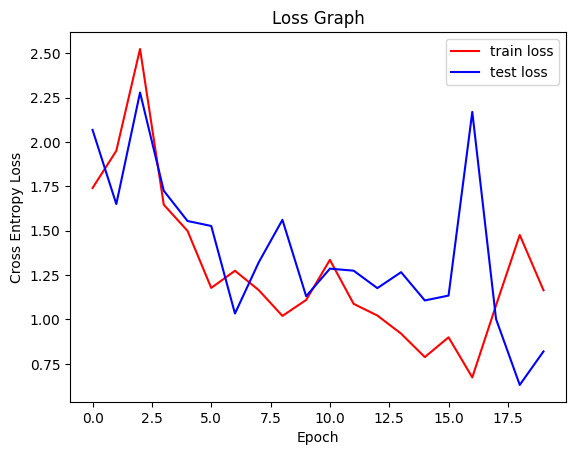

In [21]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(test_losses,'b',label='test loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

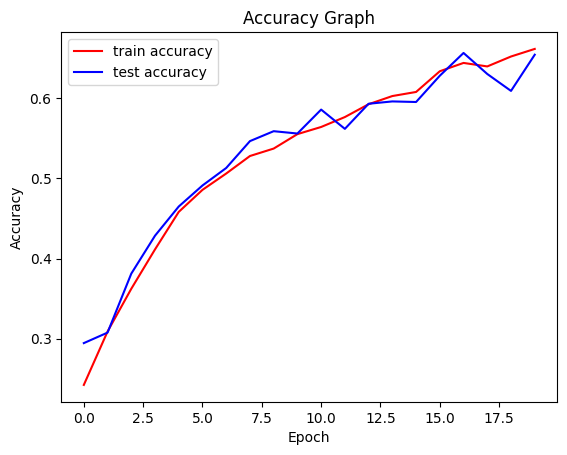

In [22]:
train_accuracies = [x/len(train_set) for x in train_correct_predictions]
test_accuracies = [x/len(test_set) for x in test_correct_predictions]
plt.plot(train_accuracies,'r',label='train accuracy')
plt.plot(test_accuracies,'b',label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show();


In [23]:
torch.save(model,'weather_image_baseline_classifier.pt')

AlexNet

In [24]:
alexnet = models.alexnet(pretrained=True)
alexnet

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:05<00:00, 42.0MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [25]:
total_params = 0

for param in alexnet.parameters():
    param.requires_grad = False
    print(param.numel())
    total_params += param.numel()

print("Total parameters of the AlexNet model:", total_params)

23232
64
307200
192
663552
384
884736
256
589824
256
37748736
4096
16777216
4096
4096000
1000
Total parameters of the AlexNet model: 61100840


In [26]:
alexnet.classifier = nn.Sequential(
    nn.Linear(9216,2048),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(2048,1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.4),
    nn.Linear(1024,11),
    nn.LogSoftmax(dim=1)
)
alexnet = alexnet.cuda()
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=2048, bias=True)
    (1): ReLU(inplace=True)
    (2): Dro

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=alexnet.parameters(),lr=0.001)
start_time = time.time()

epochs = 20

train_losses = []
test_losses = []
train_correct_predictions = []
test_correct_predictions = []

for i in range(1,epochs+1):
    train_correct = 0
    test_correct = 0

    for batch_no, (X_train, y_train) in enumerate(train_loader):
        batch_no += 1
        X_train, y_train = X_train.cuda(), y_train.cuda()
        y_pred = alexnet(X_train)
        loss = criterion(y_pred,y_train)
        predicted = torch.max(y_pred,1)[1]
        train_correct += (predicted == y_train).sum()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_no % 50 == 0:
            print(f"Epoch {i} Batch {batch_no} -> Loss: {loss.item()}")

    train_losses.append(loss.item())
    train_correct_predictions.append(train_correct.item())

    with torch.no_grad():
        for batch_no, (X_test, y_test) in enumerate(test_loader):
            X_test, y_test = X_test.cuda(), y_test.cuda()
            y_pred = alexnet(X_test)
            predicted = torch.max(y_pred,1)[1]
            test_correct += (predicted == y_test).sum()

    loss = criterion(y_pred,y_test)
    test_losses.append(loss.item())
    test_correct_predictions.append(test_correct.item())

print(f"Total time elapsed in Alexnet model training: {(time.time()-start_time)/60} minutes.")

Epoch 1 Batch 50 -> Loss: 0.873898446559906
Epoch 1 Batch 100 -> Loss: 1.0959272384643555
Epoch 1 Batch 150 -> Loss: 0.8108999133110046
Epoch 2 Batch 50 -> Loss: 0.824039101600647
Epoch 2 Batch 100 -> Loss: 0.41225168108940125
Epoch 2 Batch 150 -> Loss: 0.6209484338760376
Epoch 3 Batch 50 -> Loss: 0.6488144397735596
Epoch 3 Batch 100 -> Loss: 0.8665820360183716
Epoch 3 Batch 150 -> Loss: 0.905708909034729
Epoch 4 Batch 50 -> Loss: 0.3948570489883423
Epoch 4 Batch 100 -> Loss: 0.9375249743461609
Epoch 4 Batch 150 -> Loss: 0.5501251816749573
Epoch 5 Batch 50 -> Loss: 0.7420916557312012
Epoch 5 Batch 100 -> Loss: 0.7245008945465088
Epoch 5 Batch 150 -> Loss: 0.3269931375980377
Epoch 6 Batch 50 -> Loss: 0.6122490763664246
Epoch 6 Batch 100 -> Loss: 0.6176445484161377
Epoch 6 Batch 150 -> Loss: 0.802680253982544
Epoch 7 Batch 50 -> Loss: 0.43857499957084656
Epoch 7 Batch 100 -> Loss: 0.2519078850746155
Epoch 7 Batch 150 -> Loss: 0.7319622039794922
Epoch 8 Batch 50 -> Loss: 0.757029473781585

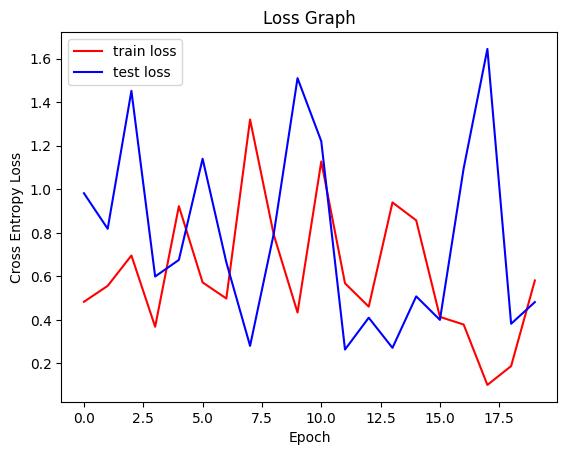

In [28]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(test_losses,'b',label='test loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();


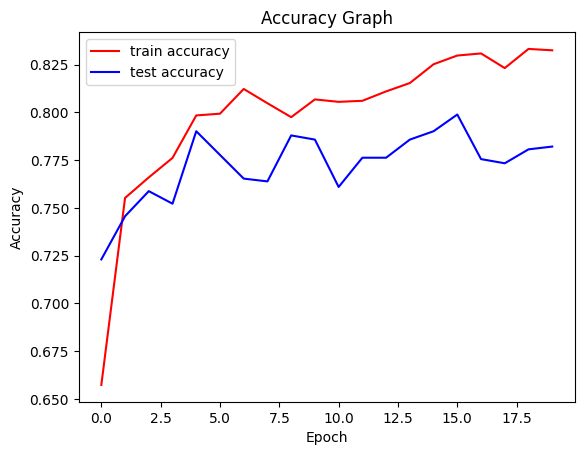

In [29]:
train_accuracies = [x/len(train_set) for x in train_correct_predictions]
test_accuracies = [x/len(test_set) for x in test_correct_predictions]

plt.plot(train_accuracies,'r',label='train accuracy')
plt.plot(test_accuracies,'b',label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show();

In [30]:
torch.save(alexnet,'weather_image_alexnet_classifier.pt')

ResNet

In [31]:
resnet = models.resnet50(pretrained=True)
resnet

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 130MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [32]:
total_params = 0

for param in resnet.parameters():
    param.requires_grad = False
    print(param.numel())
    total_params += param.numel()

print("Total parameters of pretrained ResNet50 model:", total_params)

9408
64
64
4096
64
64
36864
64
64
16384
256
256
16384
256
256
16384
64
64
36864
64
64
16384
256
256
16384
64
64
36864
64
64
16384
256
256
32768
128
128
147456
128
128
65536
512
512
131072
512
512
65536
128
128
147456
128
128
65536
512
512
65536
128
128
147456
128
128
65536
512
512
65536
128
128
147456
128
128
65536
512
512
131072
256
256
589824
256
256
262144
1024
1024
524288
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
524288
512
512
2359296
512
512
1048576
2048
2048
2097152
2048
2048
1048576
512
512
2359296
512
512
1048576
2048
2048
1048576
512
512
2359296
512
512
1048576
2048
2048
2048000
1000
Total parameters of pretrained ResNet50 model: 25557032


In [33]:
resnet.fc = nn.Sequential(
    nn.Linear(2048,1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.4),
    nn.Linear(1024,11),
    nn.LogSoftmax(dim=1)
)
resnet = resnet.cuda()
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=resnet.parameters(),lr=0.001)
start_time = time.time()

epochs = 20

train_losses = []
test_losses = []
train_correct_predictions = []
test_correct_predictions = []

for i in range(1,epochs+1):
    train_correct = 0
    test_correct = 0

    for batch_no, (X_train, y_train) in enumerate(train_loader):
        batch_no += 1
        X_train, y_train = X_train.cuda(), y_train.cuda()
        y_pred = resnet(X_train)
        loss = criterion(y_pred,y_train)
        predicted = torch.max(y_pred,1)[1]
        train_correct += (predicted == y_train).sum()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_no % 50 == 0:
            print(f"Epoch {i} Batch {batch_no} -> Loss: {loss.item()}")

    train_losses.append(loss.item())
    train_correct_predictions.append(train_correct.item())

    with torch.no_grad():
        for batch_no, (X_test, y_test) in enumerate(test_loader):
            X_test, y_test = X_test.cuda(), y_test.cuda()
            y_pred = resnet(X_test)
            predicted = torch.max(y_pred,1)[1]
            test_correct += (predicted == y_test).sum()

    loss = criterion(y_pred,y_test)
    test_losses.append(loss.item())
    test_correct_predictions.append(test_correct.item())

print(f"Total time elapsed in ResNet50 model training: {(time.time()-start_time)/60} minutes.")

Epoch 1 Batch 50 -> Loss: 0.8147901892662048
Epoch 1 Batch 100 -> Loss: 0.8152693510055542
Epoch 1 Batch 150 -> Loss: 0.6720349788665771
Epoch 2 Batch 50 -> Loss: 0.5881313681602478
Epoch 2 Batch 100 -> Loss: 0.8559955358505249
Epoch 2 Batch 150 -> Loss: 0.2685350179672241
Epoch 3 Batch 50 -> Loss: 0.6546450853347778
Epoch 3 Batch 100 -> Loss: 0.49472230672836304
Epoch 3 Batch 150 -> Loss: 0.733525812625885
Epoch 4 Batch 50 -> Loss: 0.973763644695282
Epoch 4 Batch 100 -> Loss: 0.9315181970596313
Epoch 4 Batch 150 -> Loss: 0.6877755522727966
Epoch 5 Batch 50 -> Loss: 0.9346125721931458
Epoch 5 Batch 100 -> Loss: 0.6439793705940247
Epoch 5 Batch 150 -> Loss: 0.6175610423088074
Epoch 6 Batch 50 -> Loss: 0.6261946558952332
Epoch 6 Batch 100 -> Loss: 0.4227342903614044
Epoch 6 Batch 150 -> Loss: 0.22698867321014404
Epoch 7 Batch 50 -> Loss: 0.4236995577812195
Epoch 7 Batch 100 -> Loss: 0.5345932245254517
Epoch 7 Batch 150 -> Loss: 0.6056413650512695
Epoch 8 Batch 50 -> Loss: 0.2114787995815

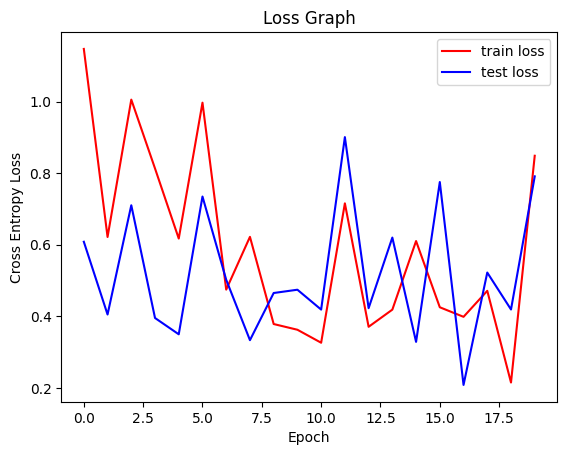

In [35]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(test_losses,'b',label='test loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();


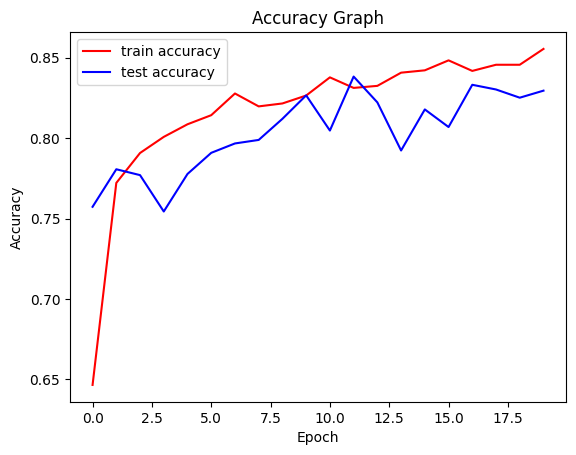

In [36]:
train_accuracies = [x/len(train_set) for x in train_correct_predictions]
test_accuracies = [x/len(test_set) for x in test_correct_predictions]

plt.plot(train_accuracies,'r',label='train accuracy')
plt.plot(test_accuracies,'b',label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show();


In [37]:
torch.save(resnet,'weather_image_resnet_classifier.pt')

VGG16

In [38]:
vgg16 = models.vgg16(pretrained=True)
vgg16

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 135MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [39]:
total_params = 0

for param in vgg16.parameters():
    param.requires_grad = False
    print(param.numel())
    total_params += param.numel()

print("Total parameters of the pretrained VGG16 model:", total_params)

1728
64
36864
64
73728
128
147456
128
294912
256
589824
256
589824
256
1179648
512
2359296
512
2359296
512
2359296
512
2359296
512
2359296
512
102760448
4096
16777216
4096
4096000
1000
Total parameters of the pretrained VGG16 model: 138357544


In [40]:
vgg16.classifier = nn.Sequential(
    nn.Linear(25088,2048),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(2048,1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.3),
    nn.Linear(1024,11),
    nn.LogSoftmax(dim=1)
)

vgg16 = vgg16.cuda()
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=vgg16.parameters(),lr=0.001)
start_time = time.time()

epochs = 20

train_losses = []
test_losses = []
train_correct_predictions = []
test_correct_predictions = []

for i in range(1,epochs+1):
    train_correct = 0
    test_correct = 0

    for batch_no, (X_train, y_train) in enumerate(train_loader):
        batch_no += 1
        X_train, y_train = X_train.cuda(), y_train.cuda()
        y_pred = vgg16(X_train)
        loss = criterion(y_pred,y_train)
        predicted = torch.max(y_pred,1)[1]
        train_correct += (predicted == y_train).sum()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_no % 50 == 0:
            print(f"Epoch {i} Batch {batch_no} -> Loss: {loss.item()}")

    train_losses.append(loss.item())
    train_correct_predictions.append(train_correct.item())

    with torch.no_grad():
        for batch_no, (X_test, y_test) in enumerate(test_loader):
            X_test, y_test = X_test.cuda(), y_test.cuda()
            y_pred = vgg16(X_test)
            predicted = torch.max(y_pred,1)[1]
            test_correct += (predicted == y_test).sum()

    loss = criterion(y_pred,y_test)
    test_losses.append(loss.item())
    test_correct_predictions.append(test_correct.item())

print(f"Total time elapsed in VGG16 model training: {(time.time()-start_time)/60} minutes.")

Epoch 1 Batch 50 -> Loss: 1.0123964548110962
Epoch 1 Batch 100 -> Loss: 1.028735637664795
Epoch 1 Batch 150 -> Loss: 0.6089531183242798
Epoch 2 Batch 50 -> Loss: 0.6066470146179199
Epoch 2 Batch 100 -> Loss: 1.6389564275741577
Epoch 2 Batch 150 -> Loss: 0.46869370341300964
Epoch 3 Batch 50 -> Loss: 0.6014057993888855
Epoch 3 Batch 100 -> Loss: 0.4343545138835907
Epoch 3 Batch 150 -> Loss: 0.7746308445930481
Epoch 4 Batch 50 -> Loss: 0.6120783090591431
Epoch 4 Batch 100 -> Loss: 0.5526392459869385
Epoch 4 Batch 150 -> Loss: 0.5588968396186829
Epoch 5 Batch 50 -> Loss: 0.6630207300186157
Epoch 5 Batch 100 -> Loss: 0.524642825126648
Epoch 5 Batch 150 -> Loss: 0.5290382504463196
Epoch 6 Batch 50 -> Loss: 0.654211699962616
Epoch 6 Batch 100 -> Loss: 0.33517226576805115
Epoch 6 Batch 150 -> Loss: 0.22624748945236206
Epoch 7 Batch 50 -> Loss: 0.2972888946533203
Epoch 7 Batch 100 -> Loss: 0.3869733512401581
Epoch 7 Batch 150 -> Loss: 0.5051278471946716
Epoch 8 Batch 50 -> Loss: 0.5625957846641

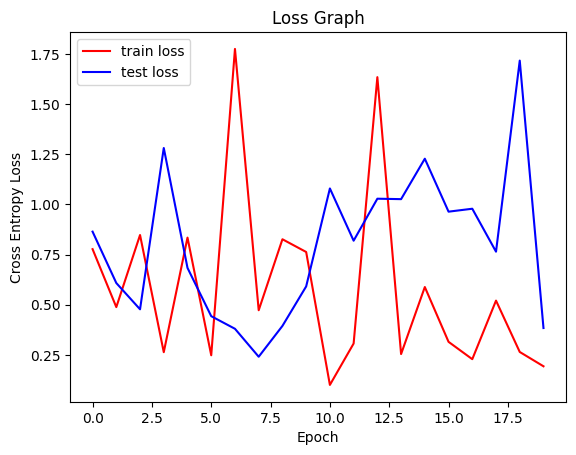

In [42]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(test_losses,'b',label='test loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

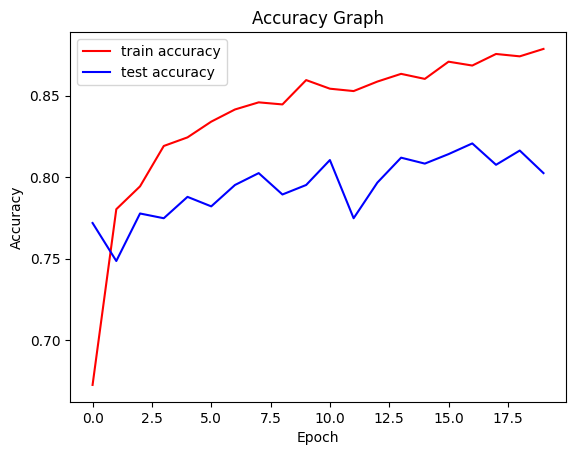

In [43]:
train_accuracies = [x/len(train_set) for x in train_correct_predictions]
test_accuracies = [x/len(test_set) for x in test_correct_predictions]

plt.plot(train_accuracies,'r',label='train accuracy')
plt.plot(test_accuracies,'b',label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show();

In [44]:
torch.save(vgg16,'weather_image_vgg16_classifier.pt')

MobileNet v3 large

In [45]:
mobilenet = models.mobilenet_v3_large(pretrained=True)
mobilenet

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 120MB/s] 


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [46]:
total_params = 0

for param in mobilenet.parameters():
    param.requires_grad = False
    print(param.numel())
    total_params += param.numel()

print("Total parameters of Mobile Net v3 Large model:", total_params)

432
16
16
144
16
16
256
16
16
1024
64
64
576
64
64
1536
24
24
1728
72
72
648
72
72
1728
24
24
1728
72
72
1800
72
72
1728
24
1728
72
2880
40
40
4800
120
120
3000
120
120
3840
32
3840
120
4800
40
40
4800
120
120
3000
120
120
3840
32
3840
120
4800
40
40
9600
240
240
2160
240
240
19200
80
80
16000
200
200
1800
200
200
16000
80
80
14720
184
184
1656
184
184
14720
80
80
14720
184
184
1656
184
184
14720
80
80
38400
480
480
4320
480
480
57600
120
57600
480
53760
112
112
75264
672
672
6048
672
672
112896
168
112896
672
75264
112
112
75264
672
672
16800
672
672
112896
168
112896
672
107520
160
160
153600
960
960
24000
960
960
230400
240
230400
960
153600
160
160
153600
960
960
24000
960
960
230400
240
230400
960
153600
160
160
153600
960
960
1228800
1280
1280000
1000
Total parameters of Mobile Net v3 Large model: 5483032


In [47]:
mobilenet.classifier = nn.Sequential(
    nn.Linear(960,2048),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(2048,1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.4),
    nn.Linear(1024,11),
    nn.LogSoftmax(dim=1)
)

mobilenet = mobilenet.cuda()
mobilenet

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [49]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=mobilenet.parameters(),lr=0.001)
start_time = time.time()

epochs = 20

train_losses = []
test_losses = []
train_correct_predictions = []
test_correct_predictions = []

for i in range(1,epochs+1):
    train_correct = 0
    test_correct = 0
    for batch_no, (X_train, y_train) in enumerate(train_loader):
        batch_no += 1
        X_train, y_train = X_train.cuda(), y_train.cuda()
        y_pred = mobilenet(X_train)
        loss = criterion(y_pred,y_train)
        predicted = torch.max(y_pred,1)[1]
        train_correct += (predicted == y_train).sum()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_no % 50 == 0:
          print(f"Epoch {i} Batch {batch_no} -> Loss: {loss.item()}")

    train_losses.append(loss.item())
    train_correct_predictions.append(train_correct.item())

    with torch.no_grad():
        for batch_no, (X_test, y_test) in enumerate(test_loader):
            X_test, y_test = X_test.cuda(), y_test.cuda()
            y_pred = mobilenet(X_test)
            predicted = torch.max(y_pred,1)[1]
            test_correct += (predicted == y_test).sum()

    loss = criterion(y_pred,y_test)
    test_losses.append(loss.item())
    test_correct_predictions.append(test_correct.item())

print(f"Total time elapsed in MobileNet v3 large model training: {(time.time()-start_time)/60} minutes.")

Epoch 1 Batch 50 -> Loss: 1.178891897201538
Epoch 1 Batch 100 -> Loss: 1.0344732999801636
Epoch 1 Batch 150 -> Loss: 0.39695554971694946
Epoch 2 Batch 50 -> Loss: 0.6536282300949097
Epoch 2 Batch 100 -> Loss: 0.6845731735229492
Epoch 2 Batch 150 -> Loss: 0.3169988989830017
Epoch 3 Batch 50 -> Loss: 0.2949441075325012
Epoch 3 Batch 100 -> Loss: 0.6898987293243408
Epoch 3 Batch 150 -> Loss: 0.2686401903629303
Epoch 4 Batch 50 -> Loss: 0.43660232424736023
Epoch 4 Batch 100 -> Loss: 0.8264120221138
Epoch 4 Batch 150 -> Loss: 0.30246812105178833
Epoch 5 Batch 50 -> Loss: 0.3907681107521057
Epoch 5 Batch 100 -> Loss: 0.36155036091804504
Epoch 5 Batch 150 -> Loss: 1.0340656042099
Epoch 6 Batch 50 -> Loss: 0.3298541009426117
Epoch 6 Batch 100 -> Loss: 0.676459550857544
Epoch 6 Batch 150 -> Loss: 0.4998342990875244
Epoch 7 Batch 50 -> Loss: 0.5011071562767029
Epoch 7 Batch 100 -> Loss: 0.46557262539863586
Epoch 7 Batch 150 -> Loss: 0.5348576903343201
Epoch 8 Batch 50 -> Loss: 0.2359212338924408

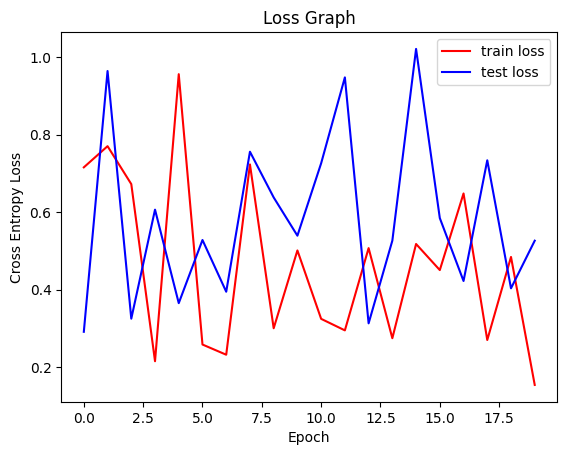

In [50]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(test_losses,'b',label='test loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

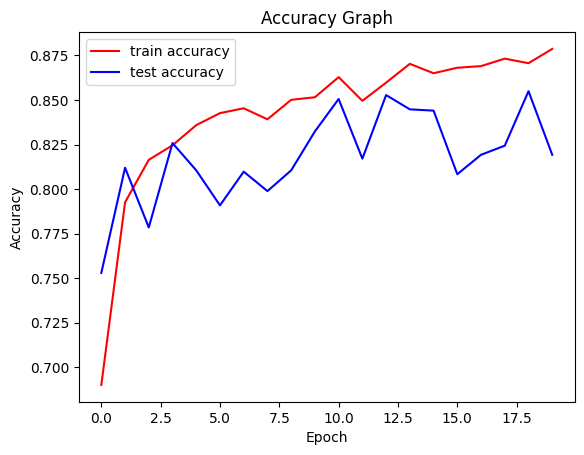

In [51]:
train_accuracies = [x/len(train_set) for x in train_correct_predictions]
test_accuracies = [x/len(test_set) for x in test_correct_predictions]

plt.plot(train_accuracies,'r',label='train accuracy')
plt.plot(test_accuracies,'b',label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show();

In [52]:
torch.save(mobilenet,'weather_image_mobilenet_classifier.pt')
torch.cuda.memory_allocated()

1275487744

In [53]:
torch.cuda.memory_reserved()

6010437632

Among all pretrained models used, the MobileNet v3 large model achieved the best performance having attained a stupendous accuracy score of more than 82.5% on the test set. The MobileNet v3 model is comptutationally efficient as well as it is suitable for use in even mobile devices and can achieve performance comparable with other SOTA pre-trained image classification models. It is closely followed by the ResNet50 model which achieved an amazing accuracy score of a little over 82% on the test set.